
Type the message to encrypt with BB84 key:  qubit


⚠️ PyQuil QVM connection failed. Switching to Qiskit simulator.
Attempt 1: QBER = 31.25%, matches 11/16 bits


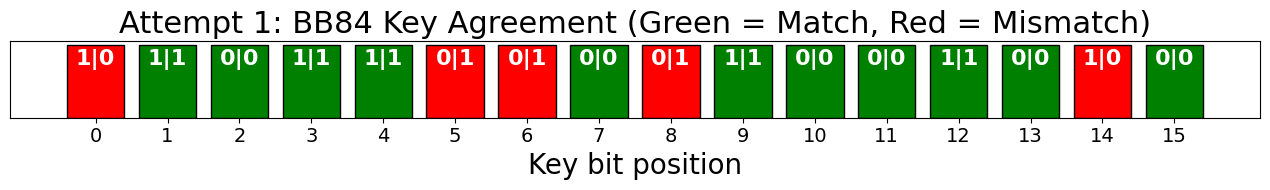

⚠️ High QBER, generating new key...
Attempt 2: QBER = 27.78%, matches 13/18 bits


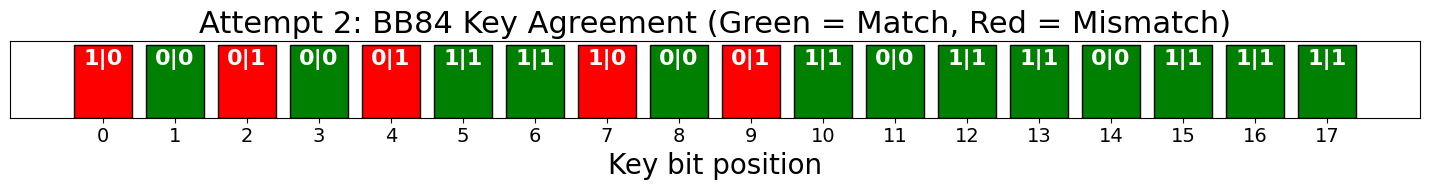

⚠️ High QBER, generating new key...
Attempt 3: QBER = 9.52%, matches 19/21 bits


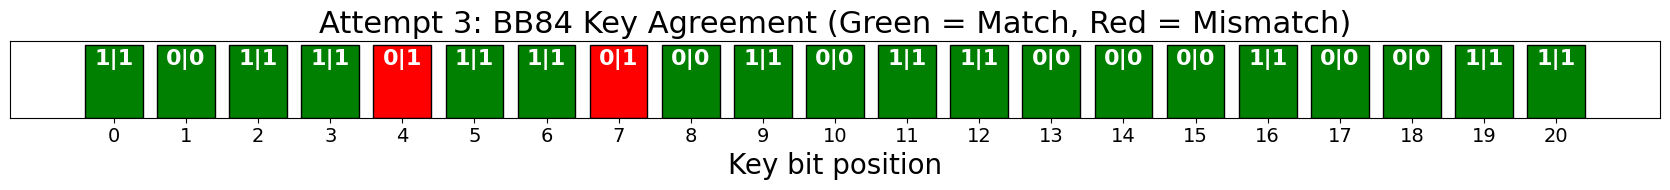

✅ Secure key obtained!

Original message: qubit
Encrypted (binary): 1100011100101101111111111101101110110000
Decrypted message: qubit


In [16]:
# ------------------------------------------------------
# BB84 Protocol Simulation + QBER Visualization + Encryption
# Automatically adjusts key length to match the message
# Saves figures as JPG
# ------------------------------------------------------

# Import standard Python libraries
from math import pi
import random
import matplotlib.pyplot as plt
import time
import os

# QuantumGateway core modules
from quantumgateway.quantum_circuit import QuantumCircuit, QuantumGate

# Translators to simulate circuits in different frameworks
from quantumgateway.quantum_translator.braket_translator import BraketTranslator
from quantumgateway.quantum_translator.cirq_translator import CirqTranslator
from quantumgateway.quantum_translator.qiskit_translator import QiskitTranslator
from quantumgateway.quantum_translator.pennylane_translator import PennyLaneTranslator
from quantumgateway.quantum_translator.pyquil_translator import PyQuilTranslator

# Core QuantumGateway functions
from quantumgateway.main import translate_to_framework, simulate_circuit

# ------------------------------------------------------
# STEP 0: Helper functions
# ------------------------------------------------------
def string_to_bits(s):
    return ''.join(f'{ord(c):08b}' for c in s)

def bits_to_string(b):
    chars = [b[i:i+8] for i in range(0, len(b), 8)]
    return ''.join(chr(int(c, 2)) for c in chars)

def xor_bits(a, b):
    b = (b * ((len(a) // len(b)) + 1))[:len(a)]
    return ''.join('0' if bit_a == bit_b else '1' for bit_a, bit_b in zip(a, b))

def visualize_key(alice_key, bob_key, attempt):
    fig, ax = plt.subplots(figsize=(len(alice_key)*0.8, 2))
    colors = ["green" if a == b else "red" for a, b in zip(alice_key, bob_key)]
    labels = [f"{a}|{b}" for a, b in zip(alice_key, bob_key)]
    bars = ax.bar(range(len(alice_key)), [1]*len(alice_key), color=colors, edgecolor="black", width=0.8)
    for rect, label in zip(bars, labels):
        ax.text(rect.get_x() + rect.get_width()/2, 0.8, label,
                ha='center', va='center', fontsize=16, color='white', weight='bold')
    ax.set_xticks(range(len(alice_key)))
    ax.set_xticklabels([f"{i}" for i in range(len(alice_key))], fontsize=14)
    ax.set_yticks([])
    ax.set_xlabel("Key bit position", fontsize=20)
    ax.set_title(f"Attempt {attempt}: BB84 Key Agreement (Green = Match, Red = Mismatch)", fontsize=22)
    plt.tight_layout()
    
    # Save figure as JPG
    if not os.path.exists("figures"):
        os.makedirs("figures")
    plt.savefig(f"figures/bb84_attempt_{attempt}.eps")
    plt.show()

# ------------------------------------------------------
# STEP 1: User input and convert to binary
# ------------------------------------------------------
message = input("\nType the message to encrypt with BB84 key: ")  
message_bin = string_to_bits(message)
num_bits = len(message_bin)

# ------------------------------------------------------
# STEP 2: Protocol parameters
# ------------------------------------------------------
eve_active = True
selected_framework = 'pyquil'  # Try PyQuil first
qber_threshold = 0.11
attempt = 0

# ------------------------------------------------------
# STEP 2b: Check PyQuil QVM connection
# ------------------------------------------------------
if selected_framework == 'pyquil':
    try:
        from pyquil import get_qc
        qc_test = get_qc('9q-square-qvm')
        qc_test.run('PRAGMA INITIALIZE')  # quick test
        print("✅ PyQuil QVM is running locally.")
    except Exception as e:
        print("⚠️ PyQuil QVM connection failed. Switching to Qiskit simulator.")
        selected_framework = 'qiskit'

# ------------------------------------------------------
# STEP 3: BB84 key generation and QBER check
# ------------------------------------------------------
while True:
    attempt += 1
    alice_bits = [random.randint(0, 1) for _ in range(num_bits)]
    alice_bases = [random.randint(0, 1) for _ in range(num_bits)]
    bob_bases = [random.randint(0, 1) for _ in range(num_bits)]
    bob_measurements = []

    if eve_active:
        eve_bases = [random.randint(0, 1) for _ in range(num_bits)]
        eve_measurements = []

    # Simulation without Eve
    if not eve_active:
        for i in range(num_bits):
            circuit = QuantumCircuit(1, 1)
            if alice_bits[i] == 1: circuit.add_gate(QuantumGate("X", [0]))
            if alice_bases[i] == 1: circuit.add_gate(QuantumGate("H", [0]))
            if bob_bases[i] == 1: circuit.add_gate(QuantumGate("H", [0]))
            circuit.add_gate(QuantumGate("MEASURE", [0, 0]))
            results = simulate_circuit(circuit, selected_framework)
            bob_measurements.append(int(list(results.keys())[0]))
    else:
        # Eve intercepting
        for i in range(num_bits):
            eve_circuit = QuantumCircuit(1, 1)
            if alice_bits[i] == 1: eve_circuit.add_gate(QuantumGate("X", [0]))
            if alice_bases[i] == 1: eve_circuit.add_gate(QuantumGate("H", [0]))
            if eve_bases[i] == 1: eve_circuit.add_gate(QuantumGate("H", [0]))
            eve_circuit.add_gate(QuantumGate("MEASURE", [0, 0]))
            results = simulate_circuit(eve_circuit, selected_framework)
            eve_measurements.append(int(list(results.keys())[0]))

        for i in range(num_bits):
            bob_circuit = QuantumCircuit(1, 1)
            if eve_measurements[i] == 1: bob_circuit.add_gate(QuantumGate("X", [0]))
            if eve_bases[i] == 1: bob_circuit.add_gate(QuantumGate("H", [0]))
            if bob_bases[i] == 1: bob_circuit.add_gate(QuantumGate("H", [0]))
            bob_circuit.add_gate(QuantumGate("MEASURE", [0, 0]))
            results = simulate_circuit(bob_circuit, selected_framework)
            bob_measurements.append(int(list(results.keys())[0]))

    # Keep only bits where Alice and Bob's bases match
    matching_indices = [i for i in range(num_bits) if alice_bases[i] == bob_bases[i]]
    alice_key = [alice_bits[i] for i in matching_indices]
    bob_key = [bob_measurements[i] for i in matching_indices]

    # Compute QBER
    if alice_key:
        matches = sum(a == b for a, b in zip(alice_key, bob_key))
        qber = 1 - matches / len(alice_key)
    else:
        qber = 1

    print(f"Attempt {attempt}: QBER = {qber:.2%}, matches {matches}/{len(alice_key)} bits")
    visualize_key(alice_key, bob_key, attempt)

    if qber <= qber_threshold:
        print("✅ Secure key obtained!")
        break
    else:
        print("⚠️ High QBER, generating new key...")

# ------------------------------------------------------
# STEP 4: Encrypt and decrypt message
# ------------------------------------------------------
binary_key = ''.join(str(bit) for bit in alice_key)
encrypted_message_bin = xor_bits(message_bin, binary_key)
decrypted_message_bin = xor_bits(encrypted_message_bin, binary_key)
decrypted_message = bits_to_string(decrypted_message_bin)

print("\nOriginal message:", message)
print("Encrypted (binary):", encrypted_message_bin)
print("Decrypted message:", decrypted_message)